In [32]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
import csv
import numpy as np
import pandas as pd

In [20]:
def tanimoto_slow(vector1, vector2):
    assert len(vector1) == len(vector2)
    ones1 = set(np.nonzero(vector1)[0])
    ones2 = set(np.nonzero(vector2)[0])
    intersec = ones1.intersection(ones2)
    union = ones1.union(ones2)
    return len(intersec) / len(union)

In [77]:
def tanimoto(vector1, vector2):
    set_bits = 0
    shared_bits = 0
    for bit1, bit2 in zip(vector1, vector2):
        if bit1 or bit2: # at least one vector has this feature
            set_bits += 1
            if bit1 and bit2: # both vectors have this feature
                shared_bits += 1
    return shared_bits / set_bits

In [22]:
print(tanimoto([0,1,1,0,0,0,1], [0,0,0,1,1,0,1]))
print(tanimoto([1, 1, 0, 0], [0, 0, 1, 1])) # share nothing
print(tanimoto([0, 1, 1, 0], [1, 0, 1, 0])) # share bit of 3
print(tanimoto([1, 1, 1, 1], [0, 0, 1, 1])) # share 2 bits of 4
print(tanimoto([1, 1, 1, 1], [0, 1, 1, 1])) # share 3 bits of 4
print(tanimoto([1, 1, 0, 0], [1, 1, 0, 0])) # share 2 bits of 2

0.2
0.0
0.3333333333333333
0.5
0.75
1.0


In [23]:
with open('./data/DOWNLOAD-ligands_for_serotonine_rec.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    serotonine_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

In [25]:
fp1 = MACCSkeys.GenMACCSKeys(drugs[12])
fp2 = MACCSkeys.GenMACCSKeys(drugs[66])
print(fp1.ToBitString())
print(fp2.ToBitString())

00000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000010000000000001001000000100000101001011000100
00000000000000000000000000100000000000000000000000100100000000000000000000001000000000000111000000010100110010000011101000010011110110001001110101110110101101011001110


In [26]:
tanimoto(fp1, fp2)

0.23255813953488372

In [30]:
DataStructs.TanimotoSimilarity(fp1, fp2)

0.23255813953488372

In [31]:
serotonine_maccs = [MACCSkeys.GenMACCSKeys(m) for m in serotonine_ligands]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]

In [34]:
#serotonine_maccs_series = pd.Series(serotonine_maccs)
#drugs_maccs_series = pd.Series(drugs_maccs)

In [42]:
def similarity_search_slow(query_fp, search_set, cutoff=0.8):
    similarities = search_set.apply(tanimoto, args=(query_fp,))
    mask = similarities >= cutoff
    hits = similarities[mask]
    return hits.sort_values(ascending=False)

In [80]:
def similarity_search(query_fp, searched_fp_set, cutoff=0.8):
    # we have no index, so we will have to just iterate through the entire searched set
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff: # similar enough for consideration
            hits.append((i, similarity))
    return sorted(hits, key=lambda x: x[1], reverse=True) # stronger hits first

In [81]:
similarity_search(drugs_maccs[16], drugs_maccs[:28])

[(16, 1.0), (21, 0.9615384615384616)]

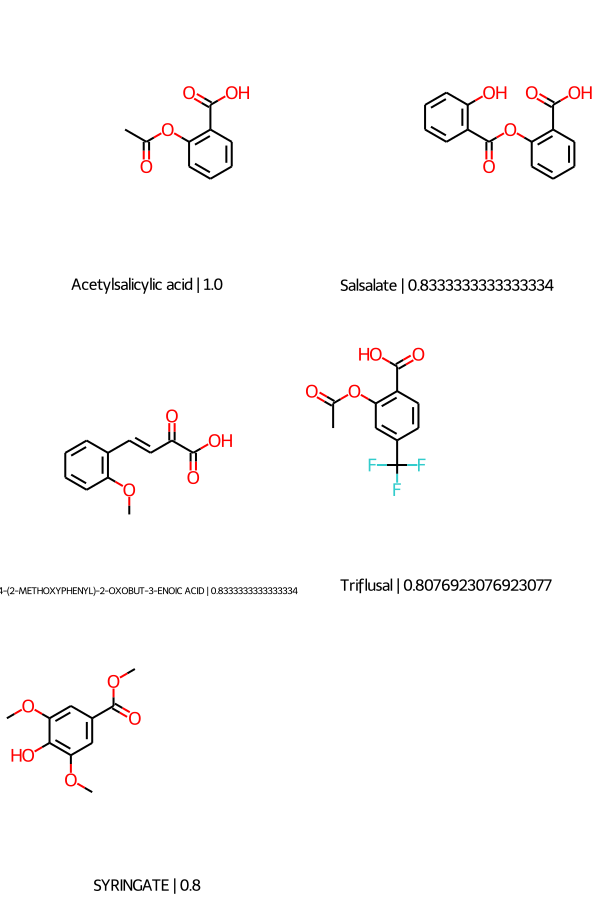

In [82]:
aspirin = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
aspirin_fp = MACCSkeys.GenMACCSKeys(aspirin)
hits = similarity_search(aspirin_fp, drugs_maccs)
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=["{} | {}".format(drugs[hit[0]].GetProp('GENERIC_NAME'), hit[1]) for hit in hits])

In [83]:
hits = similarity_search(serotonine_maccs[6], drugs_maccs)
hits

[(188, 0.8478260869565217),
 (6600, 0.8260869565217391),
 (5428, 0.8125),
 (6912, 0.8125)]

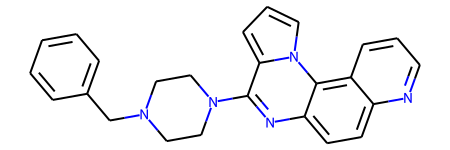

In [84]:
serotonine_ligands[6]

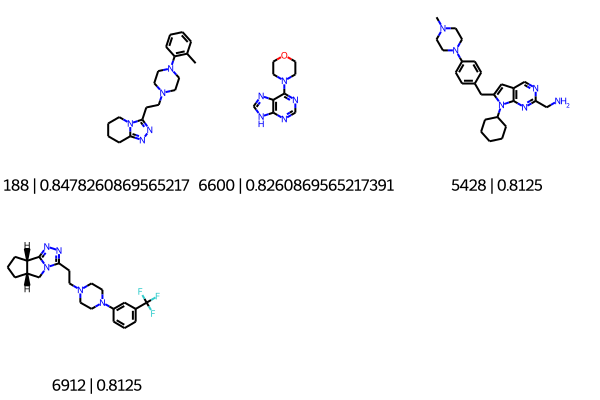

In [85]:
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits], legends=["{} | {}".format(hit[0], hit[1]) for hit in hits])

Nice. We can see the purine-like double heterocycles, also lots of nitrogen (and not many other hetero atoms) and quite a few rings connected by "stems". But not too close similarity...

In [86]:
serotonine_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in serotonine_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
              for m in drugs]


In [87]:
hits = similarity_search(serotonine_ecfp[6], drugs_ecfp)
hits

[]

In [88]:
print(DataStructs.TanimotoSimilarity(serotonine_ecfp[6], drugs_ecfp[188]))
print(DataStructs.TanimotoSimilarity(serotonine_ecfp[6], drugs_ecfp[6600]))
print(DataStructs.TanimotoSimilarity(serotonine_ecfp[6], drugs_ecfp[5428]))
print(DataStructs.TanimotoSimilarity(serotonine_ecfp[6], drugs_ecfp[6912]))


0.18421052631578946
0.14925373134328357
0.14942528735632185
0.14772727272727273


In [89]:
serotonine_ligands_queries = [(i, similarity_search(ligand_ecfp, drugs_ecfp_series))
                     for i, ligand_ecfp in enumerate(serotonine_ecfp)]
serotonine_ligands_queries

[(0, []),
 (1, []),
 (2, []),
 (3, [(841, 1.0)]),
 (4, [(470, 1.0)]),
 (5, []),
 (6, []),
 (7, []),
 (8, [(471, 1.0)]),
 (9, []),
 (10, []),
 (11, [(7016, 1.0)]),
 (12, []),
 (13, []),
 (14, []),
 (15, []),
 (16, []),
 (17, []),
 (18, []),
 (19, []),
 (20, []),
 (21, []),
 (22, []),
 (23, [(139, 1.0)]),
 (24, []),
 (25, []),
 (26, []),
 (27, []),
 (28, [(1086, 1.0)]),
 (29, [(1110, 1.0)]),
 (30, []),
 (31, [(337, 1.0)]),
 (32, [(1247, 1.0), (28, 0.8166666666666667), (4456, 0.8166666666666667)]),
 (33, [(232, 1.0)]),
 (34, []),
 (35, [(330, 1.0), (1109, 1.0), (505, 0.8596491228070176)]),
 (36, [(1098, 1.0)]),
 (37, []),
 (38, []),
 (39, []),
 (40, []),
 (41, []),
 (42, []),
 (43, []),
 (44, []),
 (45, []),
 (46, []),
 (47, []),
 (48, []),
 (49, []),
 (50, []),
 (51, []),
 (52, []),
 (53, []),
 (54, []),
 (55, []),
 (56, []),
 (57, []),
 (58, [(964, 1.0)]),
 (59, []),
 (60, []),
 (61, []),
 (62, []),
 (63, []),
 (64, []),
 (65, []),
 (66, []),
 (67, []),
 (68, []),
 (69, []),
 (70, []),


In [91]:
serotonine_ligand_hits = [hit for hit in serotonine_ligands_queries if hit[1]]
serotonine_ligand_hits

[(3, [(841, 1.0)]),
 (4, [(470, 1.0)]),
 (8, [(471, 1.0)]),
 (11, [(7016, 1.0)]),
 (23, [(139, 1.0)]),
 (28, [(1086, 1.0)]),
 (29, [(1110, 1.0)]),
 (31, [(337, 1.0)]),
 (32, [(1247, 1.0), (28, 0.8166666666666667), (4456, 0.8166666666666667)]),
 (33, [(232, 1.0)]),
 (35, [(330, 1.0), (1109, 1.0), (505, 0.8596491228070176)]),
 (36, [(1098, 1.0)]),
 (58, [(964, 1.0)]),
 (74, [(387, 1.0)]),
 (81, [(265, 1.0), (275, 1.0), (822, 1.0)]),
 (83, [(4064, 1.0)]),
 (84, [(209, 1.0)]),
 (85, [(6954, 1.0)]),
 (88,
  [(397, 1.0),
   (4370, 0.8581560283687943),
   (4029, 0.8333333333333334),
   (3655, 0.8102189781021898)]),
 (92, [(214, 1.0)]),
 (93, [(1208, 1.0)]),
 (94, [(5344, 1.0)]),
 (95, [(546, 1.0)]),
 (96, [(305, 1.0)]),
 (97, [(784, 1.0)]),
 (98, [(446, 1.0)]),
 (99, [(919, 1.0)]),
 (100, [(4646, 1.0)]),
 (107, [(1108, 1.0)]),
 (108, [(115, 1.0)]),
 (111, [(847, 1.0)]),
 (114, [(187, 1.0), (881, 1.0), (186, 0.8604651162790697)]),
 (121, [(1004, 1.0), (2588, 1.0)]),
 (122, [(93, 0.95)]),
 (123

In [92]:
len(serotonine_ligands_queries), len(serotonine_ligand_hits)

(1876, 653)

Unlike mTOR, about a third of the ligands has a similar structure in DrugBank. There are way too many hits to visualize them all, but at least the best ones...

In [93]:
serotonine_ligand_hits[0]

(3, [(841, 1.0)])

In the above, the serotonine receptor ligand 3 hits DrugBank structure 841 fully by Tanimoto similarity over ECFP4 fingerprints. To visualize the structures:

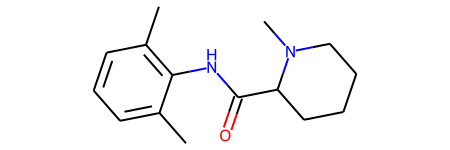

In [94]:
serotonine_ligands[serotonine_ligand_hits[0][0]]

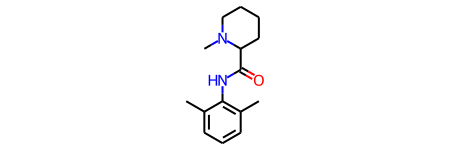

In [102]:
drugs[serotonine_ligand_hits[0][1][0][0]]

Ah, exactly the same thing!

Let's do it again:

In [103]:
serotonine_ligand_hits[1]

(4, [(470, 1.0)])

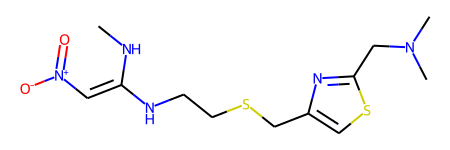

In [104]:
serotonine_ligands[serotonine_ligand_hits[1][0]]

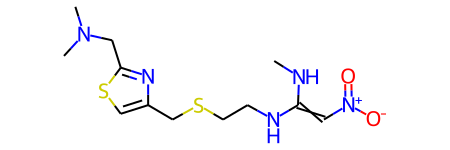

In [105]:
drugs[serotonine_ligand_hits[1][1][0][0]]

It looks like we keep getting identical hits. It seems hit no. 8 should be a bit more interesting.

(What is that broken double bond in the right part of the structure?)

In [106]:
serotonine_ligand_hits[8]

(32, [(1247, 1.0), (28, 0.8166666666666667), (4456, 0.8166666666666667)])

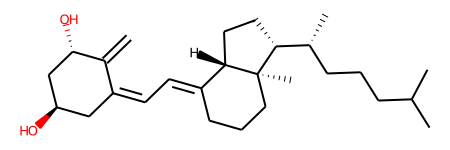

In [107]:
serotonine_ligands[serotonine_ligand_hits[8][0]]

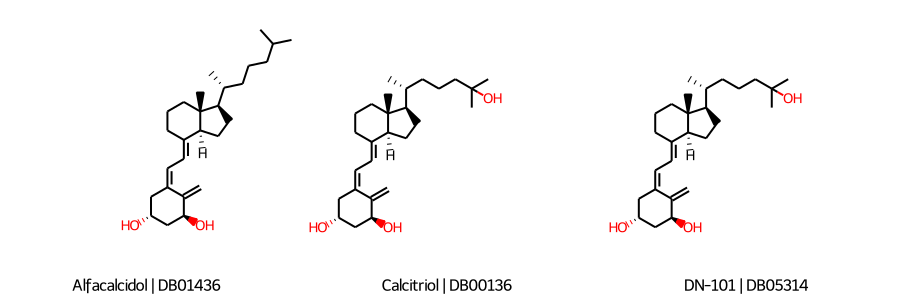

In [108]:
hit_mols = [drugs[idx] for idx, sim in serotonine_ligand_hits[8][1]]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols])

Now it becomes a bit more interesting, although most of the variability is in conformation.

In [109]:
drugs_hitcounts = {}
for ligand, hits in serotonine_ligand_hits:
    for hit, similarity in hits:
        drugs_hitcounts[hit] = drugs_hitcounts.get(hit, 0) + 1
drugs_hitcounts

{841: 1,
 470: 1,
 471: 1,
 7016: 1,
 139: 1,
 1086: 1,
 1110: 1,
 337: 1,
 1247: 1,
 28: 1,
 4456: 1,
 232: 1,
 330: 3,
 1109: 3,
 505: 3,
 1098: 1,
 964: 1,
 387: 1,
 265: 1,
 275: 1,
 822: 1,
 4064: 1,
 209: 1,
 6954: 1,
 397: 1,
 4370: 1,
 4029: 1,
 3655: 1,
 214: 1,
 1208: 1,
 5344: 1,
 546: 1,
 305: 1,
 784: 1,
 446: 1,
 919: 3,
 4646: 1,
 1108: 1,
 115: 1,
 847: 1,
 187: 2,
 881: 2,
 186: 2,
 1004: 1,
 2588: 1,
 93: 1,
 1013: 2,
 1041: 2,
 2679: 2,
 1608: 1,
 952: 1,
 1112: 1,
 1951: 1,
 1123: 1,
 690: 1,
 566: 2,
 302: 2,
 937: 2,
 366: 1,
 925: 2,
 476: 2,
 252: 2,
 2706: 1,
 3914: 1,
 6977: 1,
 425: 1,
 92: 1,
 668: 1,
 608: 1,
 332: 3,
 876: 3,
 579: 4,
 144: 1,
 1019: 1,
 953: 1,
 1053: 2,
 878: 1,
 928: 3,
 6929: 3,
 5247: 1,
 5477: 1,
 722: 1,
 410: 1,
 141: 1,
 462: 1,
 1369: 1,
 1024: 1,
 581: 1,
 399: 1,
 308: 1,
 644: 1,
 809: 1,
 246: 1,
 1089: 1,
 920: 1,
 1215: 1,
 618: 5,
 315: 1,
 2384: 1,
 554: 5,
 4150: 1,
 97: 1,
 966: 1,
 1056: 1,
 1113: 3,
 580: 1,
 938: 1,


In [110]:
ordered_drugs_hitcounts = {k: v for k, v in sorted(drugs_hitcounts.items(), key=lambda item: item[1], reverse=True)}
ordered_drugs_hitcounts

{618: 5,
 554: 5,
 579: 4,
 90: 4,
 456: 4,
 2940: 4,
 330: 3,
 1109: 3,
 505: 3,
 919: 3,
 332: 3,
 876: 3,
 928: 3,
 6929: 3,
 1113: 3,
 455: 3,
 833: 3,
 187: 2,
 881: 2,
 186: 2,
 1013: 2,
 1041: 2,
 2679: 2,
 566: 2,
 302: 2,
 937: 2,
 925: 2,
 476: 2,
 252: 2,
 1053: 2,
 4542: 2,
 408: 2,
 639: 2,
 861: 2,
 1396: 2,
 493: 2,
 98: 2,
 210: 2,
 242: 2,
 1128: 2,
 426: 2,
 223: 2,
 199: 2,
 289: 2,
 991: 2,
 1518: 2,
 279: 2,
 389: 2,
 1076: 2,
 1087: 2,
 1212: 2,
 278: 2,
 1663: 2,
 3548: 2,
 888: 2,
 6930: 2,
 453: 2,
 4312: 2,
 231: 2,
 830: 2,
 1077: 2,
 923: 2,
 218: 2,
 3498: 2,
 840: 2,
 1066: 2,
 1411: 2,
 714: 2,
 508: 2,
 320: 2,
 732: 2,
 841: 1,
 470: 1,
 471: 1,
 7016: 1,
 139: 1,
 1086: 1,
 1110: 1,
 337: 1,
 1247: 1,
 28: 1,
 4456: 1,
 232: 1,
 1098: 1,
 964: 1,
 387: 1,
 265: 1,
 275: 1,
 822: 1,
 4064: 1,
 209: 1,
 6954: 1,
 397: 1,
 4370: 1,
 4029: 1,
 3655: 1,
 214: 1,
 1208: 1,
 5344: 1,
 546: 1,
 305: 1,
 784: 1,
 446: 1,
 4646: 1,
 1108: 1,
 115: 1,
 847: 1,
 1

In [111]:
hottest_hits = [drug_index for drug_index, count in ordered_drugs_hitcounts.items() if count >= 2]

C:\ProgramFiles\Anaconda3\envs\cdd\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


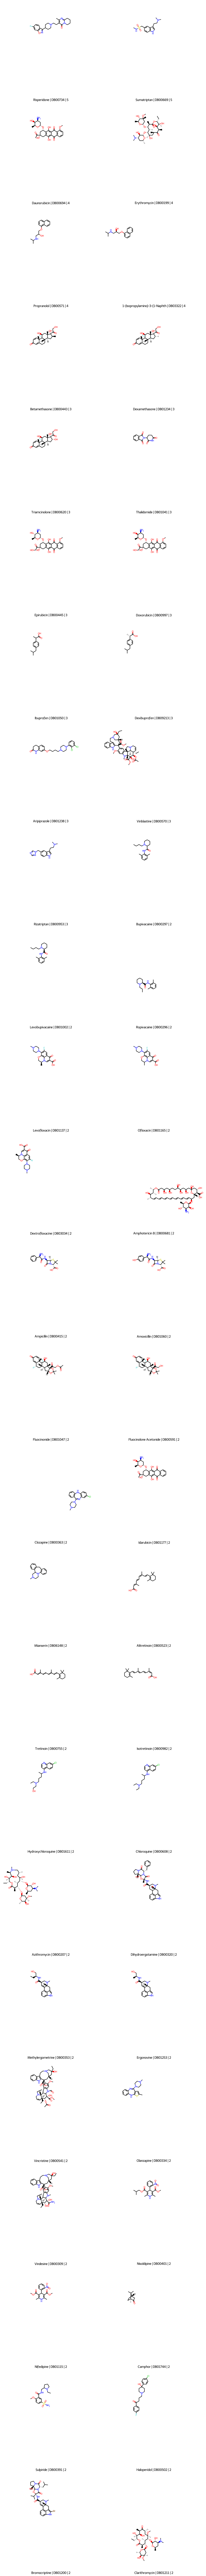

In [112]:
hit_mols = [drugs[i] for i in hottest_hits]
Draw.MolsToGridImage(hit_mols, molsPerRow=2, subImgSize=(500,500),
                     legends=["{} | {} | {}".format(drugs[i].GetProp('GENERIC_NAME')[:30], # just cut off too long IUPAC stuff
                                                    drugs[i].GetProp('DRUGBANK_ID'),
                                                    drugs_hitcounts[i])
                              for i in ordered_drugs_hitcounts])

Interesting, quite a lot of antibiotics and cytostatics.

However, the first hits are:

Risperidone, an antipsychotic drug.
Sumatriptan, a migrane and headache treatment.

That's pretty understandable, given we were qerying by the ligands of the serotonin receptor. Now the weird things start:

Daunorubicin, a chemotherapeutic.
Erythromycin, an antibiotic.
Propranolol, a beta blocker.
1-(Isopropylamino)-3-(1-naphthylamino)-2-propanol, whatever that is.
Betamethasone, a steroid medication for autoimmune conditions.
Several other corticoids, cytostatics and antibiotics, also ibuprofen.

Not exactly what I would expect to be similar to serotonin :/. I would rather have expected caffeine, unlike in the mtor set...

By the way, this is what serotonin looks like:

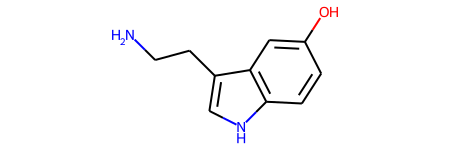

In [114]:
 Chem.MolFromSmiles("C1=CC2=C(C=C1O)C(=CN2)CCN")

In [116]:
def distance_function(index1, index2, *args, fingerprints=serotonine_ecfp,
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [117]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

In [121]:
len(serotonine_ligands)

1876

In [123]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(serotonine_ligands), 20))
picked

[1358,
 0,
 261,
 935,
 1009,
 858,
 863,
 875,
 1014,
 1163,
 1651,
 333,
 621,
 525,
 1313,
 1086,
 96,
 1579,
 1530,
 1494]

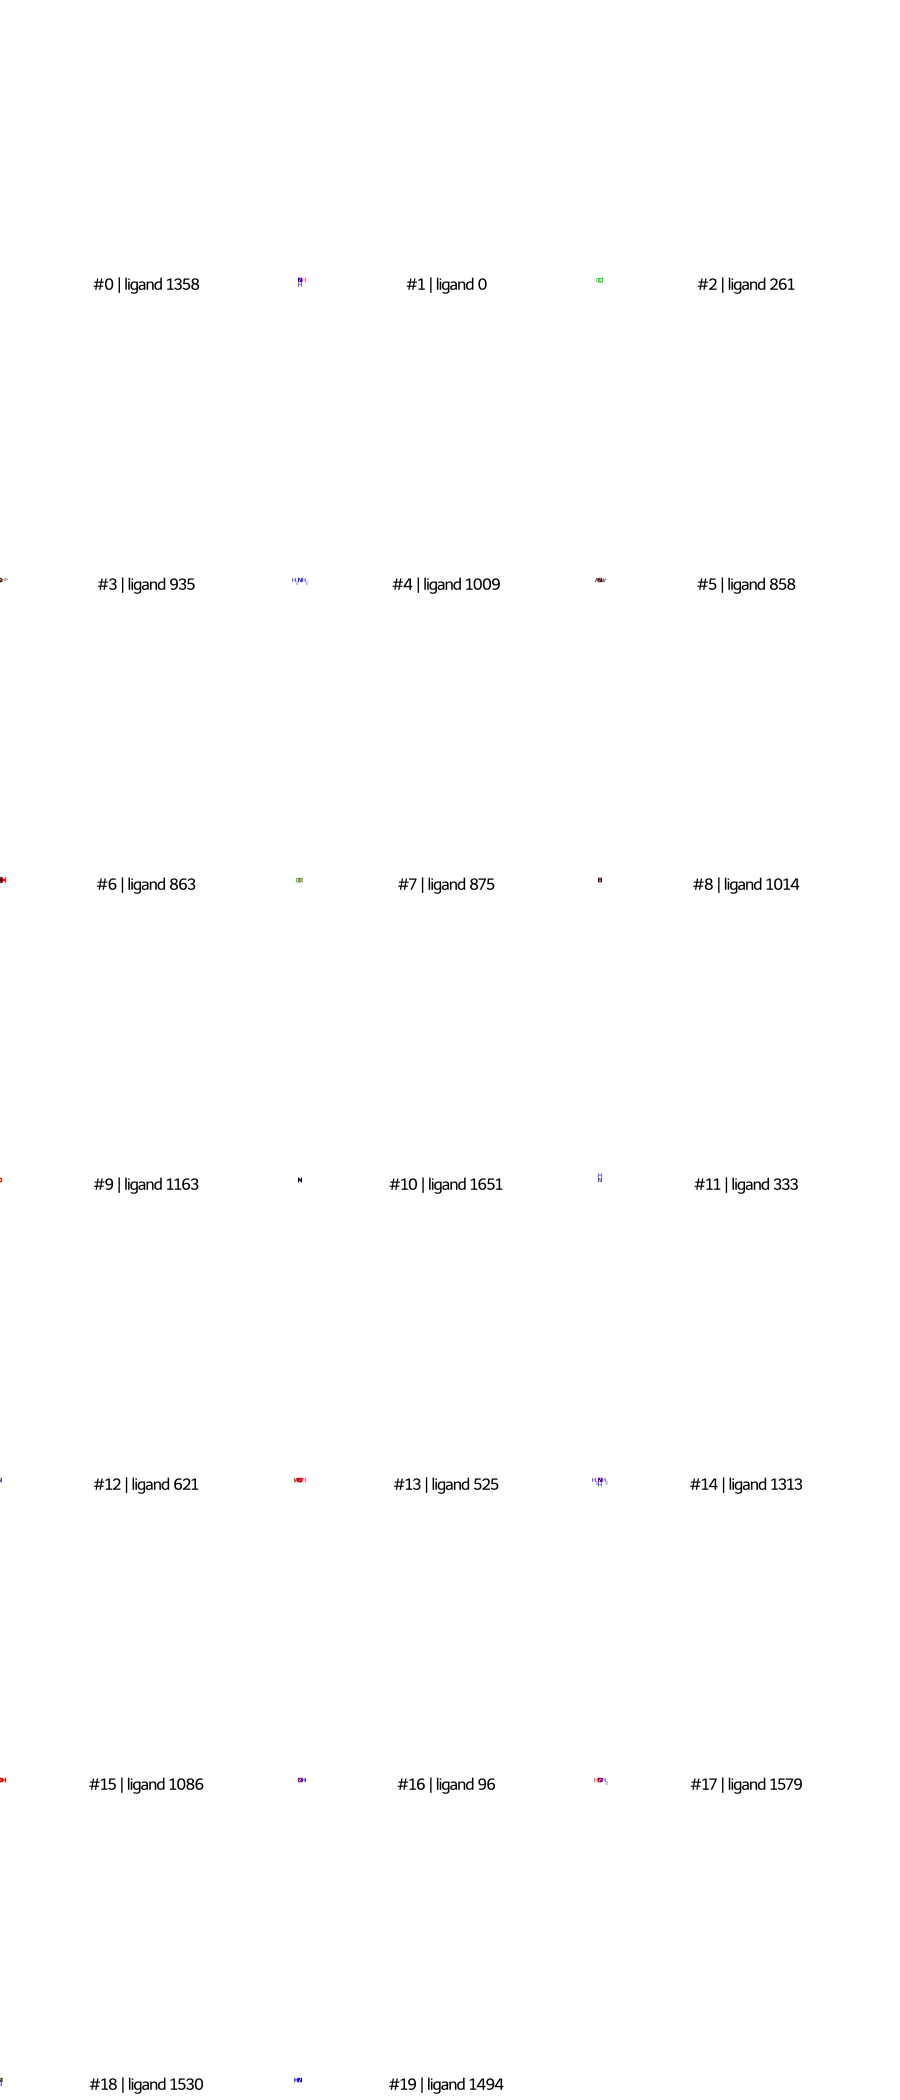

In [128]:
Draw.MolsToGridImage([serotonine_ligands[i] for i in picked], molsPerRow=3, subImgSize=(300,300),
                     legends=["#{} | ligand {}".format(i, hit) for i, hit in enumerate(picked)])

?!? Why are they so tiny?

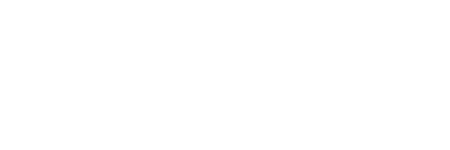

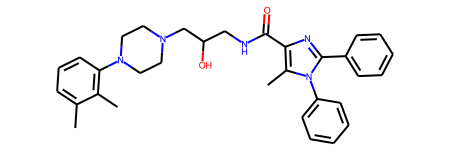

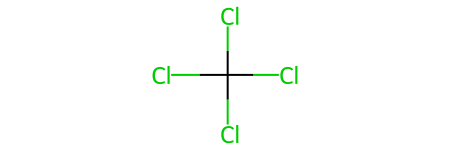

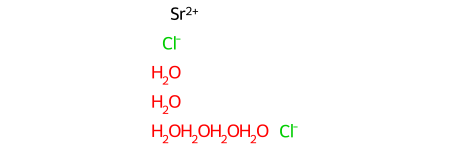

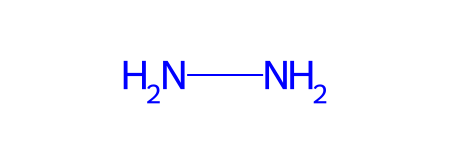

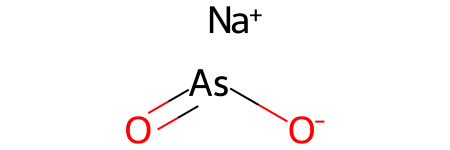

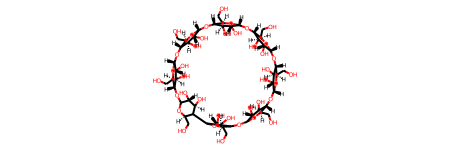

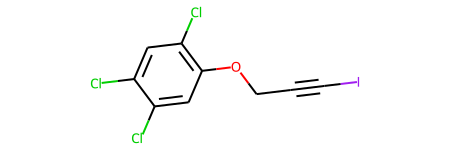

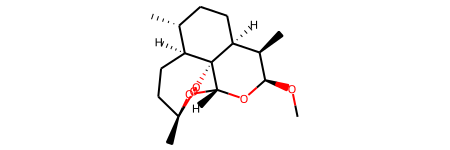

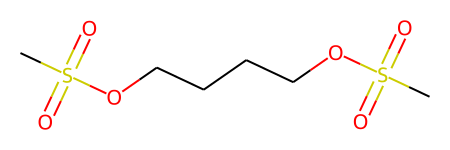

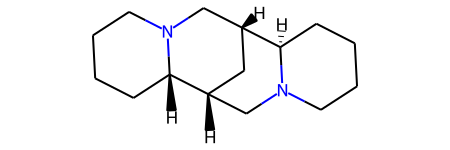

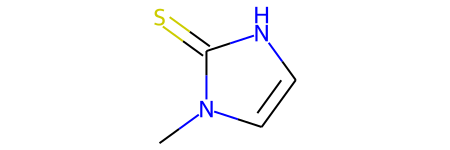

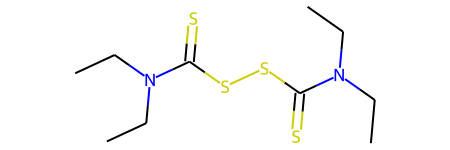

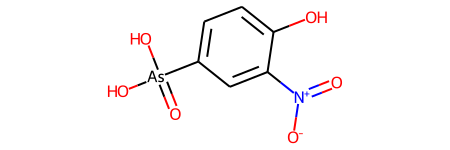

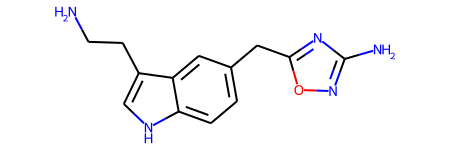

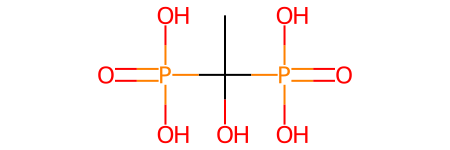

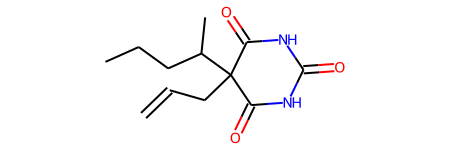

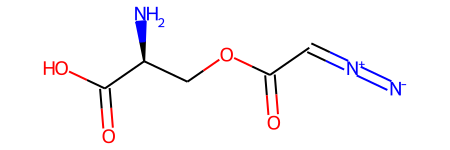

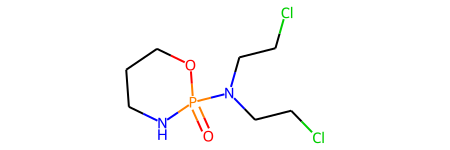

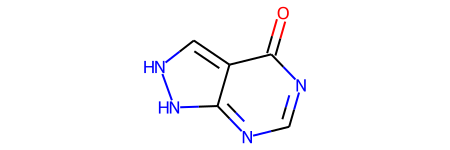

In [130]:
for picked_mol in picked:
    display(serotonine_ligands[picked_mol])

They sure look diverse. These are some weeeeird structures. It seems the ligand set is diverse enough so that we can keep picking different molecules.